Dataset loaded successfully.
Data preprocessing (scaling 'Time' and 'Amount') complete.

Original data shape: Class
0    284315
1       492
Name: count, dtype: int64
Training data shape (before SMOTE): Class
0    227451
1       394
Name: count, dtype: int64
Test data shape: Class
0    56864
1       98
Name: count, dtype: int64

Applying SMOTE to the training data: 
Training data shape (after SMOTE): Class
0    227451
1    227451
Name: count, dtype: int64


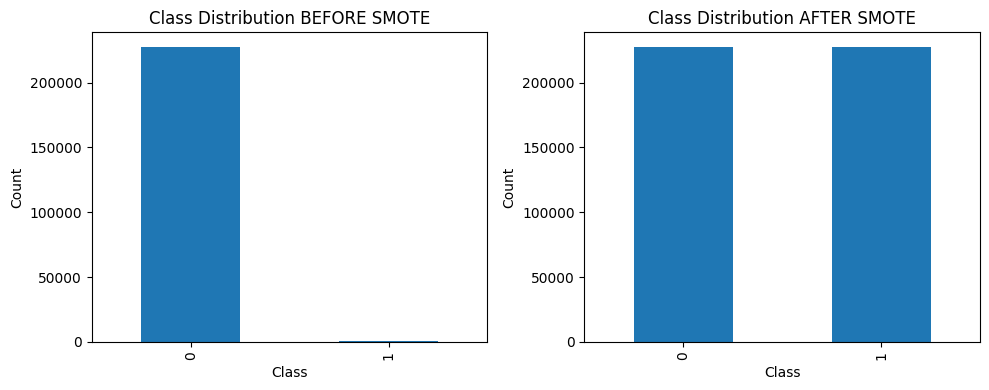


Training models on SMOTE-resampled data

--- Training Logistic Regression ---
Evaluation on the TEST set:

Confusion Matrix:
[[55406  1458]
 [    8    90]]

Classification Report:
              precision    recall  f1-score   support

 Genuine (0)       1.00      0.97      0.99     56864
   Fraud (1)       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

Average Precision-Recall Score (AUPRC): 0.7482

Training Logistic Regression on IMBALANCED data (for comparison)

--- Training Logistic Regression (Imbalanced) ---
Evaluation on the TEST set:

Confusion Matrix:
[[56851    13]
 [   35    63]]

Classification Report:
              precision    recall  f1-score   support

 Genuine (0)       1.00      1.00      1.00     56864
   Fraud (1)       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro

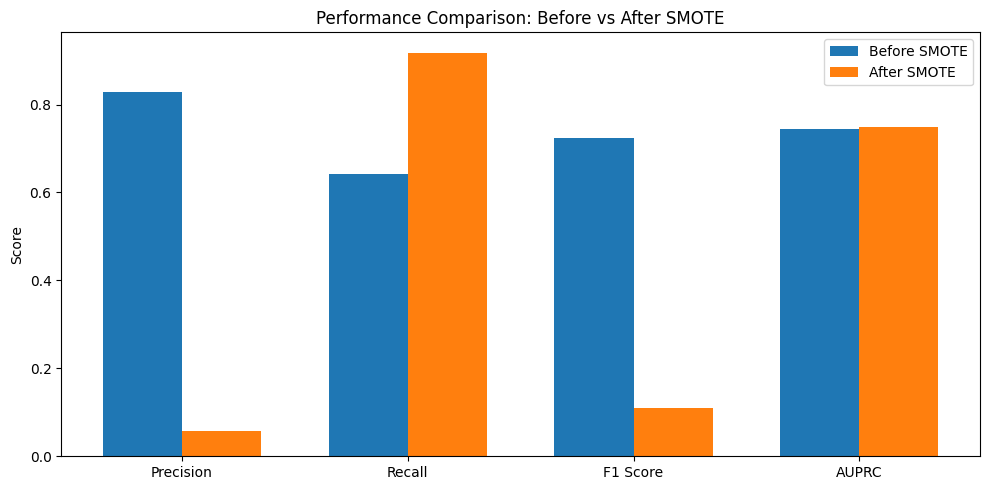

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_data(filepath='/creditcard.csv'):

    try:
        data = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: '{filepath}' not found.")
        print("Please download the dataset from Kaggle and place it in the script's directory.")
        return None, None

    print("Dataset loaded successfully.")

    scaler = StandardScaler()

    data['scaled_amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
    data['scaled_time'] = scaler.fit_transform(data['Time'].values.reshape(-1, 1))

    # Drop the original 'Time' and 'Amount' columns
    data = data.drop(['Time', 'Amount'], axis=1)

    # Reorder columns to put 'Class' at the end
    cols = [col for col in data.columns if col != 'Class'] + ['Class']
    data = data[cols]

    # Define features (X) and target (y)
    X = data.drop('Class', axis=1)
    y = data['Class']

    print("Data preprocessing (scaling 'Time' and 'Amount') complete.")

    return X, y

def train_and_evaluate(models, X_train, y_train, X_test, y_test):

    for name, model in models.items():
        print(f"\n--- Training {name} ---")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)


        if hasattr(model, "predict_prob"):
            y_prob = model.predict_prob(X_test)[:, 1]
        else:

            y_prob = model.decision_function(X_test)

            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())

        print("Evaluation on the TEST set:")

        # Confusion Matrix
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        # Classification Report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Genuine (0)', 'Fraud (1)']))

        # Average Precision-Recall Score (AUPRC)
        auprc = average_precision_score(y_test, y_prob)
        print(f"Average Precision-Recall Score (AUPRC): {auprc:.4f}")

        # Return metrics for comparison
        cr = classification_report(y_test, y_pred, output_dict=True)
        return {
            "precision": cr["1"]["precision"],
            "recall": cr["1"]["recall"],
            "f1": cr["1"]["f1-score"],
            "auprc": auprc
        }

def main():

    X, y = load_and_preprocess_data()

    if X is None or y is None:
        return

    # 1. Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nOriginal data shape: {y.value_counts()}")
    print(f"Training data shape (before SMOTE): {y_train.value_counts()}")
    print(f"Test data shape: {y_test.value_counts()}")

    # 2. Handle Class Imbalance using SMOTE
    print("\nApplying SMOTE to the training data: ")
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    print(f"Training data shape (after SMOTE): {y_train_res.value_counts()}")

    #Visualization of Data Class Before & After SMOTE
    import matplotlib.pyplot as plt

    # Before SMOTE
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    y_train.value_counts().plot(kind='bar')
    plt.title("Class Distribution BEFORE SMOTE")
    plt.xlabel("Class")
    plt.ylabel("Count")

    # After SMOTE
    plt.subplot(1,2,2)
    y_train_res.value_counts().plot(kind='bar')
    plt.title("Class Distribution AFTER SMOTE")
    plt.xlabel("Class")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()


    # 3. Define Model
    models = {
        "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    }

    # 4. Train and Evaluate on Resampled Data
    print("\nTraining models on SMOTE-resampled data")
    metrics_after = train_and_evaluate(models, X_train_res, y_train_res, X_test, y_test)

    print("\nTraining Logistic Regression on IMBALANCED data (for comparison)")
    lr_imbalanced = LogisticRegression(random_state=42, max_iter=1000)
    metrics_before = train_and_evaluate(
        {"Logistic Regression (Imbalanced)": lr_imbalanced},
        X_train, y_train, X_test, y_test)

    #Visualising Model Performance Difference

    metrics = ["precision", "recall", "f1", "auprc"]

    before_vals = [metrics_before[m] for m in metrics]
    after_vals = [metrics_after[m] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    plt.figure(figsize=(10, 5))
    plt.bar(x - width/2, before_vals, width, label='Before SMOTE')
    plt.bar(x + width/2, after_vals, width, label='After SMOTE')

    plt.xticks(x, ["Precision", "Recall", "F1 Score", "AUPRC"])
    plt.ylabel("Score")
    plt.title("Performance Comparison: Before vs After SMOTE")
    plt.legend()
    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    main()